<H1 style="text-align: center">EEEM068 - Applied Machine Learning</H1>
<H1 style="text-align: center">Workshop 04</H1>
<H1 style="text-align: center">Convolutional Neural Networks and Transfer Learning Tutorial</H1>

## Introduction
In this tutorial, we will implement a convolutional neural network (CNN) model for classifying natural images. Specifically, we will use the STL-10 dataset for training and testing our model. In this workshop, we will use [PyTorch](https://pytorch.org/) deep learning framework to complete our task.

## STL-10 Dataset

The [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/) is an image recognition dataset for developing supervised and unsupervised deep learning algorithms. It contains 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck, containing 500 training and 800 test images per class. Each image is of size $96 \times 96$ pixels. More detials on the STL-10 dataset can be found in here: https://cs.stanford.edu/~acoates/stl10

<img src="https://cs.stanford.edu/~acoates/stl10/images.png"  width="400" height="400">

Similar to MNIST, since this dataset is already implemented at the torchvision [dataset collections](https://pytorch.org/vision/stable/index.html), we don't have to implement the data generator for this dataset and will utilise the one available from torchvision. However, an example of custon data generator can be found within the transfer learning section of this tutorial.

### Dataset and DataLoader

In the following cell, we will be defining datasets and data loaders necessary for our training. Details on datasets and dataloaders can be found in the [documentation](https://pytorch.org/vision/stable/datasets.html).

In [4]:
import torch
import torchvision

# Before defining datasets, lets define how images should be transformed. This is
# because the transformations should go with the definitions of datasets. In this
# tutorial we will using simple transformations, such as (1) image to tensor, (2)
# normalization.
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Once we have the transformations defined, lets define the train and test sets
train_dataset = torchvision.datasets.STL10('dataset/',
                                           split='train',
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.STL10('dataset/',
                                          split='test',
                                          download=True,
                                          transform=image_transform)

# Now, lets define batch size, batch size is how much data you feed for training
# in one iteration
batch_size_train = 256 # We use smaller batch size here for training
batch_size_test = 1024 # We use bigger batch size for testing

# Once we have the datasets defined, lets define the data loaders as follows
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=True)

### Example Image
Lets have a look on how images from STL-10 dataset looks like. Since the images are already normalized, their resolutions might have slightly changed. To visualize the original images, we should have ideally apply a reverse transformation which is avoided to keep this tutorial simple and brief.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Label: tensor(8)


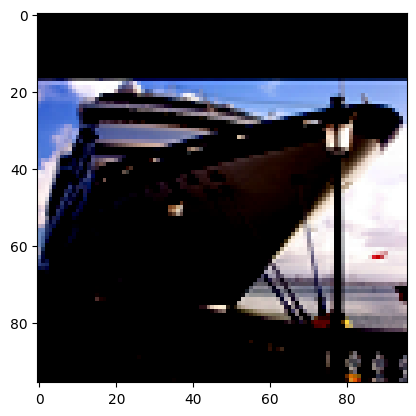

In [7]:
# import plot library
import matplotlib.pyplot as plt
# iterate the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
# get the first data
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0))
print("Label: " + str(labels[0]))

## Model
Now, we have to define trainable layers with parameters and put them inside a model. Have a look on the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module) of `nn.Module` and read more about different layers and functionalities of PyTorch there. Here we are going to implement various versions of AlexNet model and use it for classification. In this model, we are going to use the following functions or modules:

* `nn.Conv2d()`: It is a PyTorch module that applies a 2D convolution over an input signal composed of several input planes. More details are available on the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

* `nn.MaxPool2d()`: It is also a module that applies a 2D max pooling over an input signal composed of several input planes. Please have a look on this [documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) for more details.

* `nn.AdaptiveAvgPool2d()`: It is a module that applies a 2D adaptive average pooling over an input signal composed of several input planes. Given an output size, this function automatically select the stride and kernel size to adapt the need of target size. More details on this can be found in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html).

* `nn.Sequential()`: It is a sequential container. Modules will be added to it in the order they are passed in the constructor. Please check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) for more details.

* `nn.Linear()`: It is a module that applies a linear transformation to the incoming data. More details can be found in its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear).

* `nn.ReLU()`: It is also a module that applies element-wise the rectified linear unit function. Its [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu) can explain more.

* `nn.Dropout()`: This module randomly zeroes some of the elements of the input tensor with probability `p`. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) for more details.

One can define a model in several ways. Below, we show some of them.

In [9]:
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Below you can see one way of defining the model class, where each individual
## layer is defined as an instance variable.
class AlexNet1(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet1, self).__init__()
        # input channel 3, output channel 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        # relu non-linearity
        self.relu1 = nn.ReLU()
        # max pooling
        self.max_pool2d1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # input channel 64, output channel 192
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.max_pool2d2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # input channel 192, output channel 384
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        # input channel 384, output channel 256
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        # input channel 256, output channel 256
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool2d5 = nn.MaxPool2d(kernel_size=3, stride=2)
        # adaptive pooling
        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        #dropout layer
        self.dropout1 = nn.Dropout()
        # linear layer
        self.linear1 = nn.Linear(in_features=9216, out_features=4096, bias=True)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.linear2 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool2d1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2d2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.max_pool2d5(x)
        x = self.adapt_pool(x)
        # Note how we are flattening the feature map, B x C x H x W -> B x C*H*W
        x = x.reshape(x.shape[0], -1)
        x = self.dropout1(x)
        x = self.linear1(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        x = self.relu7(x)
        x = self.linear3(x)
        return x

## Below you can see another way of defining the model class, where some layers
## together are defined as an instance variable.
class AlexNet2(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(6, 6))
            )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True)
            )

    def forward(self, x):
        x = self.features(x)
        # Note how we are flattening the feature map, B x C x H x W -> B x C*H*W
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Below we define the model as defined in the torchvision package and haven't
## initialised with pretrained weights (see pretrained=False flag)
class AlexNet3(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet3, self).__init__()
        from torchvision import models
        alexnet = models.alexnet(weights=None)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        # Please note how to change the last layer of the classifier for a new dataset
        # ImageNet-1K has 1000 classes, but STL-10 has 10 classes
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # Note how we are flattening the feature map, B x C x H x W -> B x C*H*W
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Below we define the model as defined in the torchvision package and initialised
## with pretrained weights (see pretrained=True flag)
class AlexNet4(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet4, self).__init__()
        from torchvision import models
        alexnet = models.alexnet(weights='IMAGENET1K_V1')
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        # Please note how to change the last layer of the classifier for a new dataset
        # ImageNet-1K has 1000 classes, but STL-10 has 10 classes
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # Note how we are flattening the feature map, B x C x H x W -> B x C*H*W
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Initialization
Once we have the model defined, lets instantiate it and set other hyperparameters.

#### Model
We will initialize the model, transfer to the desired device and set the parameters to receive gradients.

In [10]:
# define the model, we could use any of the models AlexNet1, AlexNet2, AlexNet3, AlexNet4
model = AlexNet2(10) # since STL-10 dataset has 10 classes, we set num_classes = 10
# device: cuda (gpu) or cpu
device = "cuda"
# map to device
model = model.to(device) # `model.cuda()` will also do the same job
# make the parameters trainable
for param in model.parameters():
    param.requires_grad = True

#### Optimizer
For updating the parameters, PyTorch provides the package torch.optim that has most popular optimizers implemented. In this tutorial, we will be using the `torch.optim.Adam` optimizer.


In [12]:
import torch.optim as optim
## some hyperparameters related to optimizer
learning_rate = 0.0001
weight_decay = 0.0005
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Average Meter
It is a simple class for keeping training statistics, such as losses and accuracies etc. The `.val` field usually holds the statistics for the current batch, whereas the `.avg` field hold statistics for the current epoch.

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train and Test Functions

In [18]:
from tqdm.notebook import tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data)
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg

##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
        # after fetching the data transfer the model to the
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        # check which of the predictions are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))

## Training Loop
Training loop containing alternating train and test phase. Below we are iterating the loops 5 times, you can iterate more times.

In [21]:
# import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter
# create TensorBoard logger
writer = SummaryWriter('runs/stl10_experiment_1')
# number of epochs we decide to train
num_epoch = 30
for epoch in range(1, num_epoch + 1):
    epoch_loss = train(model, device, train_loader, optimizer)
    writer.add_scalar('training_loss', epoch_loss, global_step = epoch)
test(model, device, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.2953



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.2192



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.1834



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.1549



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.0889



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.0339



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 1.0290



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.9364



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.9200



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.8596



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.7636



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.7484



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.6835



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.6584



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.5796



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.4754



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.5125



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.5548



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.4095



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.3354



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.2940



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.2248



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.2054



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.2672



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.2267



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.1509



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.0988



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.1041



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.0773



  0%|          | 0/20 [00:00<?, ?it/s]

Train: Average loss: 0.0586

Test: Average loss: 2.5584, Accuracy: 4556/8000 (56.95%)



### Training loss curve

The TensorBoard file in the folder runs/stl10_experiment_1 now contains a training loss curve over number of epochs. To start the TensorBoard visualizer, simply run the following statements.

In [20]:
# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%reload_ext tensorboard
%tensorboard --logdir runs/stl10_experiment_1

### Summary
Show the summary of the model. It shows the number of parameters in layerwise as well as the total number of parameters. It also shows the memories required for training the model.

In [22]:
from torchsummary import summary
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]          23,296
              ReLU-2           [-1, 64, 23, 23]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         590,080
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

## Transfer Learning
Transfer learning is a machine learning paradigm where a model developed for a task is reused as the starting point for a model on a second task. In this workshop, you will learn how to classifiy sketches using pretrained model trained on [ImageNet-1K](http://image-net.org/). In this part of the workshop, we will use the pretrained weights of AlexNet (note the `pretrained=True` flag in `AlexNet4` model above) available from PyTorch to classify sketch images from the [TU-Berlin dataset](http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/). This is a very good example where knowledge or weights learned from natural images could be used for solving a classification task on completely different domains, such as sketch.

## TU-Berlin Dataset
TU-Berlin dataset contains over 20,000 human drawn sketches evenly distributed over 250 object categories. Some of the sketches from the dataset can be seen below.

![TU-Berlin](https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg)

More details on the dataset can be found here: http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/. Lets download the dataset and prepare it for usage.

In [25]:
import os
if not os.path.exists('sketches_png.zip'):
    !wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
    !unzip -q sketches_png.zip
    !rm sketches_png.zip
    !mv png tu_berlin

--2025-03-01 21:26:24--  http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
Resolving cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)... 130.149.80.52
Connecting to cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)|130.149.80.52|:80... connected.
200 OKequest sent, awaiting response... 
Length: 550098987 (525M) [application/zip]
Saving to: ‘sketches_png.zip’

sketches_png.zip    100%[===================>] 524.62M  19.7MB/s    in 31s     

2025-03-01 21:26:55 (16.9 MB/s) - ‘sketches_png.zip’ saved [550098987/550098987]



### Split into Train and Test Set

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('tu_berlin/filelist.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.3, test_size=0.1, stratify=classes)

### Custom Dataset
Since TU-Berlin is not implemented as a data generator within the torchvision package, we have to implement a custom data generator for this. One need to inherit the [`data.Dataset` class](https://pytorch.org/docs/stable/data.html) of PyTorch for designing a data generator for a dataset. The custom class should override the following methods:

* `__len__` so that `len(dataset)` returns the size of the dataset.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get *i*th sample.

Now lets create a dataset class for our TU-Berlin dataset. We will set the location of the sketches inside the `__init__` function, but leave the loading image sketch images for the `__getitem__` function. This way is memory efficient because all the images are not stored in the memory at once but read as required.

In [29]:
from PIL import Image
import torch.utils.data as data
class TUBerlin(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        # location of the dataset
        self.root = root
        # list of files
        self.files = files
        # list of classes
        self.classes = classes
        # transforms
        self.transforms = transforms

    def __getitem__(self, item):
        # read the image
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        # class for that image
        class_ = self.classes[item]
        # apply transformation
        if self.transforms:
            image = self.transforms(image)
        # return the image and class
        return image, class_

    def __len__(self):
        # return the total number of images
        return len(self.files)

### Dataset and DataLoader
In the following cell, we are defining the datasets and data loaders. The usage of different functions are alike to the example mentioned above.

In [30]:
import torch
import torchvision
# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 256 # We use a small batch size here for training
batch_size_test = 1024 # We use bigger batch size for testing

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# image datasets
train_dataset = TUBerlin('tu_berlin/', train_files, train_classes,
                         transforms=image_transform)
test_dataset = TUBerlin('tu_berlin/', test_files, test_classes,
                        transforms=image_transform)
# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=True, num_workers=2)

### Example Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].


Label: door handle


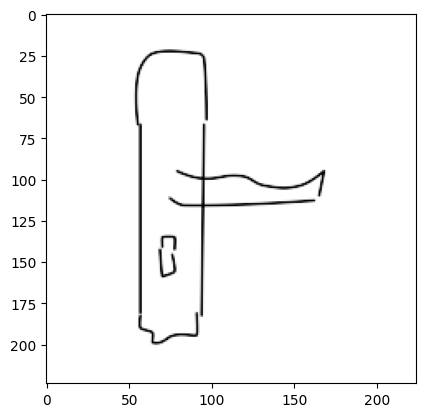

In [31]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

## Initialization

Please read the comments and understand the purpose of different lines of code.

### Model

Please check below how to make some of the layers not trainable and other trainable.

In [47]:
# define the model which contains pretrained weights from ImageNet
model = AlexNet4(250) # note the pretrained=True flag in the AlexNet4 model
# device: cuda (gpu) or cpu
device = "cuda"
# map to device
model = model.to(device)
################################################################################
################################# IMPORTANT ####################################
################################################################################
# one can choose which parameters of the model to train or finetune
# Setting 1: make all the parameters of the model trainable
for param in model.parameters():
    param.requires_grad = True

# Setting 2: make only the last layer of the classifier handle trainable
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.classifier[6].parameters():
#     param.requires_grad = True

# Setting 3: make all the parameters of the conv layer (features handle)
# not trainable and others (classifier handle) trainable
# for param in model.features.parameters():
#     param.requires_grad = False
# for param in model.classifier.parameters():
#     param.requires_grad = True

parameters = filter(lambda p: p.requires_grad, model.parameters())

### Optimizer

In [48]:
## create model and optimizer
learning_rate = 0.0001
weight_decay = 0.0005
# define optimizer
optimizer = optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

## Training Loop
Training loop for several epochs. Perform testing after training the model for some epochs.

In [49]:
num_epoch = 5
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer)
test(model, device, test_loader)

  0%|          | 0/24 [00:00<?, ?it/s]

Train: Average loss: 5.3653



  0%|          | 0/24 [00:00<?, ?it/s]

Train: Average loss: 3.3997



  0%|          | 0/24 [00:00<?, ?it/s]

Train: Average loss: 1.9535



  0%|          | 0/24 [00:00<?, ?it/s]

Train: Average loss: 1.2868



  0%|          | 0/24 [00:00<?, ?it/s]

Train: Average loss: 0.8760

Test: Average loss: 1.8512, Accuracy: 1126/2000 (56.30%)



## Summary
Show the summary of the model. It shows the number of parameters in layerwise as well as the total number of parameters. It also shows the memories required for training the model.

In [51]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25